In [25]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from xgboost import plot_importance
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Load the data
data = pd.read_excel('SignedPlayersDatasetVALORANT.xlsx')
data['date'] = pd.to_datetime(data['date'])
# Fix name errors
data = data.replace('\n','', regex=True)
data = data.replace(' ','', regex=True)
test_data = pd.read_excel('Test Dataset VALORANT VCT DATASET.xlsx').dropna(how='any',axis=0)
test_data['date'] = pd.to_datetime(test_data['date'])

In [3]:
data

,date,player,rounds,rating,average_combat_score,kills_deaths,average_damage_per_round,kills_per_round,assists_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths
0,2022-10-07,Cryocells,119,1.22,249.6,1.39,158.8,0.89,0.11,0.15,0.06,0.24,0.06,106,76,13,18,7
1,2022-08-31,Cryocells,285,1.15,232.2,1.27,143.4,0.85,0.13,0.18,0.13,0.24,0.19,242,191,36,50,36
2,2023-02-13,Cryocells,175,1.00,219.3,1.01,137.5,0.75,0.25,0.13,0.18,0.18,0.00,131,130,54,23,32
3,2022-08-31,bang,157,1.04,192.0,1.08,129.1,0.71,0.36,0.07,0.09,0.40,0.29,112,104,56,11,14
4,2023-02-13,bang,175,0.99,200.1,0.98,134.5,0.74,0.34,0.13,0.12,0.39,0.05,129,131,59,22,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2022-08-31,yay,492,1.26,254.6,1.50,159.8,0.93,0.09,0.20,0.08,0.26,0.15,460,306,42,96,40
414,2023-02-13,yay,89,1.11,201.6,1.24,127.4,0.75,0.15,0.15,0.12,0.29,0.08,67,54,13,13,11
415,2022-10-04,hoody,128,1.11,242.8,1.08,155.6,0.82,0.30,0.12,0.08,0.30,0.18,105,97,38,15,10
416,2023-02-13,hoody,97,0.96,189.0,0.94,135.4,0.63,0.16,0.06,0.08,0.23,0.20,61,65,16,6,8


In [4]:
# Select features and target variable
features = ['kills_per_round', 'assists_per_round', 'average_damage_per_round',
            'first_kills_per_round', 'first_deaths_per_round', 'headshot_percentage',
            'clutch_success_percentage', 'total_kills', 'total_deaths', 'total_assists',
            'total_first_kills', 'total_first_deaths']

target_variable = 'average_combat_score'

In [12]:
#Old Split
'''
X_train = data[features]
X_test = test_data[features]
y_train = data[target_variable]
y_test = test_data[target_variable]
'''
X_test_other = test_data[features]
y_test_other = test_data[target_variable]
None

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target_variable], test_size=0.2, random_state=42)

In [20]:
X_train

,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths
336,0.68,0.32,123.7,0.05,0.07,0.25,0.35,118,123,56,8,13
31,0.66,0.35,121.7,0.03,0.07,0.29,0.22,146,153,77,7,16
84,0.82,0.29,148.4,0.11,0.04,0.34,0.00,37,32,13,5,2
287,0.63,0.26,118.0,0.07,0.07,0.32,0.18,260,282,107,30,30
317,0.78,0.28,148.0,0.11,0.08,0.30,0.17,174,146,62,25,17
...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.82,0.25,159.1,0.11,0.06,0.28,0.20,312,255,95,42,24
106,0.76,0.24,137.4,0.11,0.13,0.25,0.14,159,148,50,23,27
270,0.82,0.23,158.0,0.19,0.19,0.22,0.05,139,129,39,32,32
348,0.53,0.23,102.1,0.03,0.05,0.17,0.05,58,82,25,3,5


In [ ]:
# Initialize the XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
# Train the model
model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test.to_numpy())

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [ ]:
#With Hyperparameter tuning

In [ ]:
#Create model pipeline
from sklearn.pipeline import Pipeline

estimators = [
    ('clf', XGBRegressor(objective='reg:squarederror', random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)

In [ ]:
#Set up hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=100, scoring='neg_mean_squared_error', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values
# Put final parameters in 4.2.3

In [ ]:
#Train opt

In [ ]:
opt.fit(X_train, y_train)

In [ ]:
#Evaluate the model and make predictions

In [ ]:
opt.best_estimator_

In [ ]:
y_pred = opt.predict(X_test.to_numpy())

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [ ]:
#Measure feature importance 

In [ ]:
opt.best_estimator_.steps

In [5]:
#Save Models

filename1 = 'model no tune.sav'
filename2 = 'model.sav'

In [ ]:
pickle.dump(model, open(filename1, 'wb'))

In [ ]:
xgboost_step = opt.best_estimator_.steps[0]
xgboost_model = xgboost_step[1]

pickle.dump(xgboost_model, open(filename2, 'wb'))

In [6]:
#Load Model

model = pickle.load(open(filename1, 'rb'))
opt = pickle.load(open(filename2, 'rb'))

In [ ]:
opt

In [27]:
# Evaluate the unoptimized model
y_pred = model.predict(X_test.to_numpy())
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R-squared: {r2}')

Mean Squared Error: 32.38491847406828
Mean Absolute Percentage Error: 0.02330253455000798
R-squared: 0.9675218963876215


In [29]:
# Evaluate the optimized model
y_pred = opt.predict(X_test.to_numpy())
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R-squared: {r2}')

Mean Squared Error: 29.449433682061105
Mean Absolute Percentage Error: 0.021484968393441457
R-squared: 0.9704658278137176


In [32]:
# Evaluate the unoptimized model to other data
y_pred_other = model.predict(X_test_other.to_numpy())
mse_other = mean_squared_error(y_test_other, y_pred_other)
mape_other = mean_absolute_percentage_error(y_test_other, y_pred_other)
r2_other = r2_score(y_test_other, y_pred_other)
print(f'Mean Squared Error: {mse_other}')
print(f'Mean Absolute Percentage Error: {mape_other}')
print(f'R-squared: {r2_other}')

Mean Squared Error: 78.29743571572608
Mean Squared Error: 0.03444894469976452
R-squared: 0.9274915341883713


In [31]:
# Evaluate the model to other data
y_pred_other = opt.predict(X_test_other.to_numpy())
mse_other = mean_squared_error(y_test_other, y_pred_other)
mape_other = mean_absolute_percentage_error(y_test_other, y_pred_other)
r2_other = r2_score(y_test_other, y_pred_other)
print(f'Mean Squared Error: {mse_other}')
print(f'Mean Absolute Percentage Error: {mape_other}')
print(f'R-squared: {r2_other}')

Mean Squared Error: 62.225466027989164
Mean Squared Error: 0.03031193734132893
R-squared: 0.9423752127402443


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

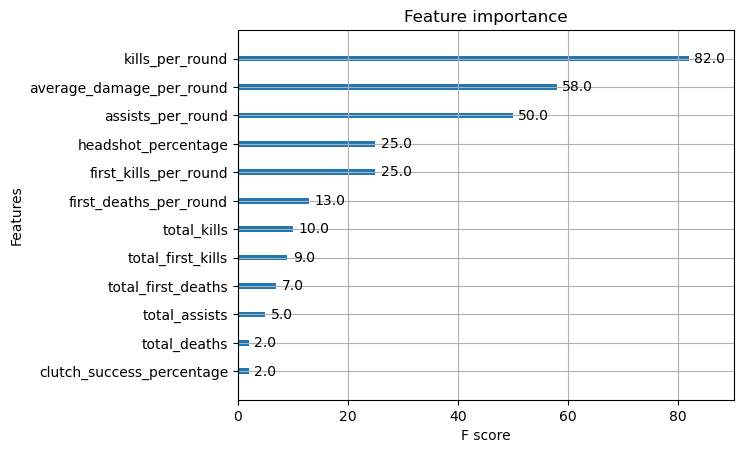

In [10]:
#Predict importance of each feature
plot_importance(opt)

In [ ]:
from pdpbox import pdp
# PDPs show the relationship between a feature and the predicted outcome while keeping other features constant. 
# Create PDP for a specific feature
pdp_feature = pdp.pdp_isolate(opt, X_train, X_train.columns, feature='kills_per_round')
pdp.pdp_plot(pdp_feature, 'kills_per_round')
plt.show()

In [ ]:
#Predict and analyze models

In [17]:
predictions = model.predict(X_test)
predictions_optimized = opt.predict(X_test)

In [18]:
y_pred = opt.predict(X_test.to_numpy())
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Squared Error: {mape}')

Mean Squared Error: 29.449433682061105
Mean Squared Error: 0.021484968393441457


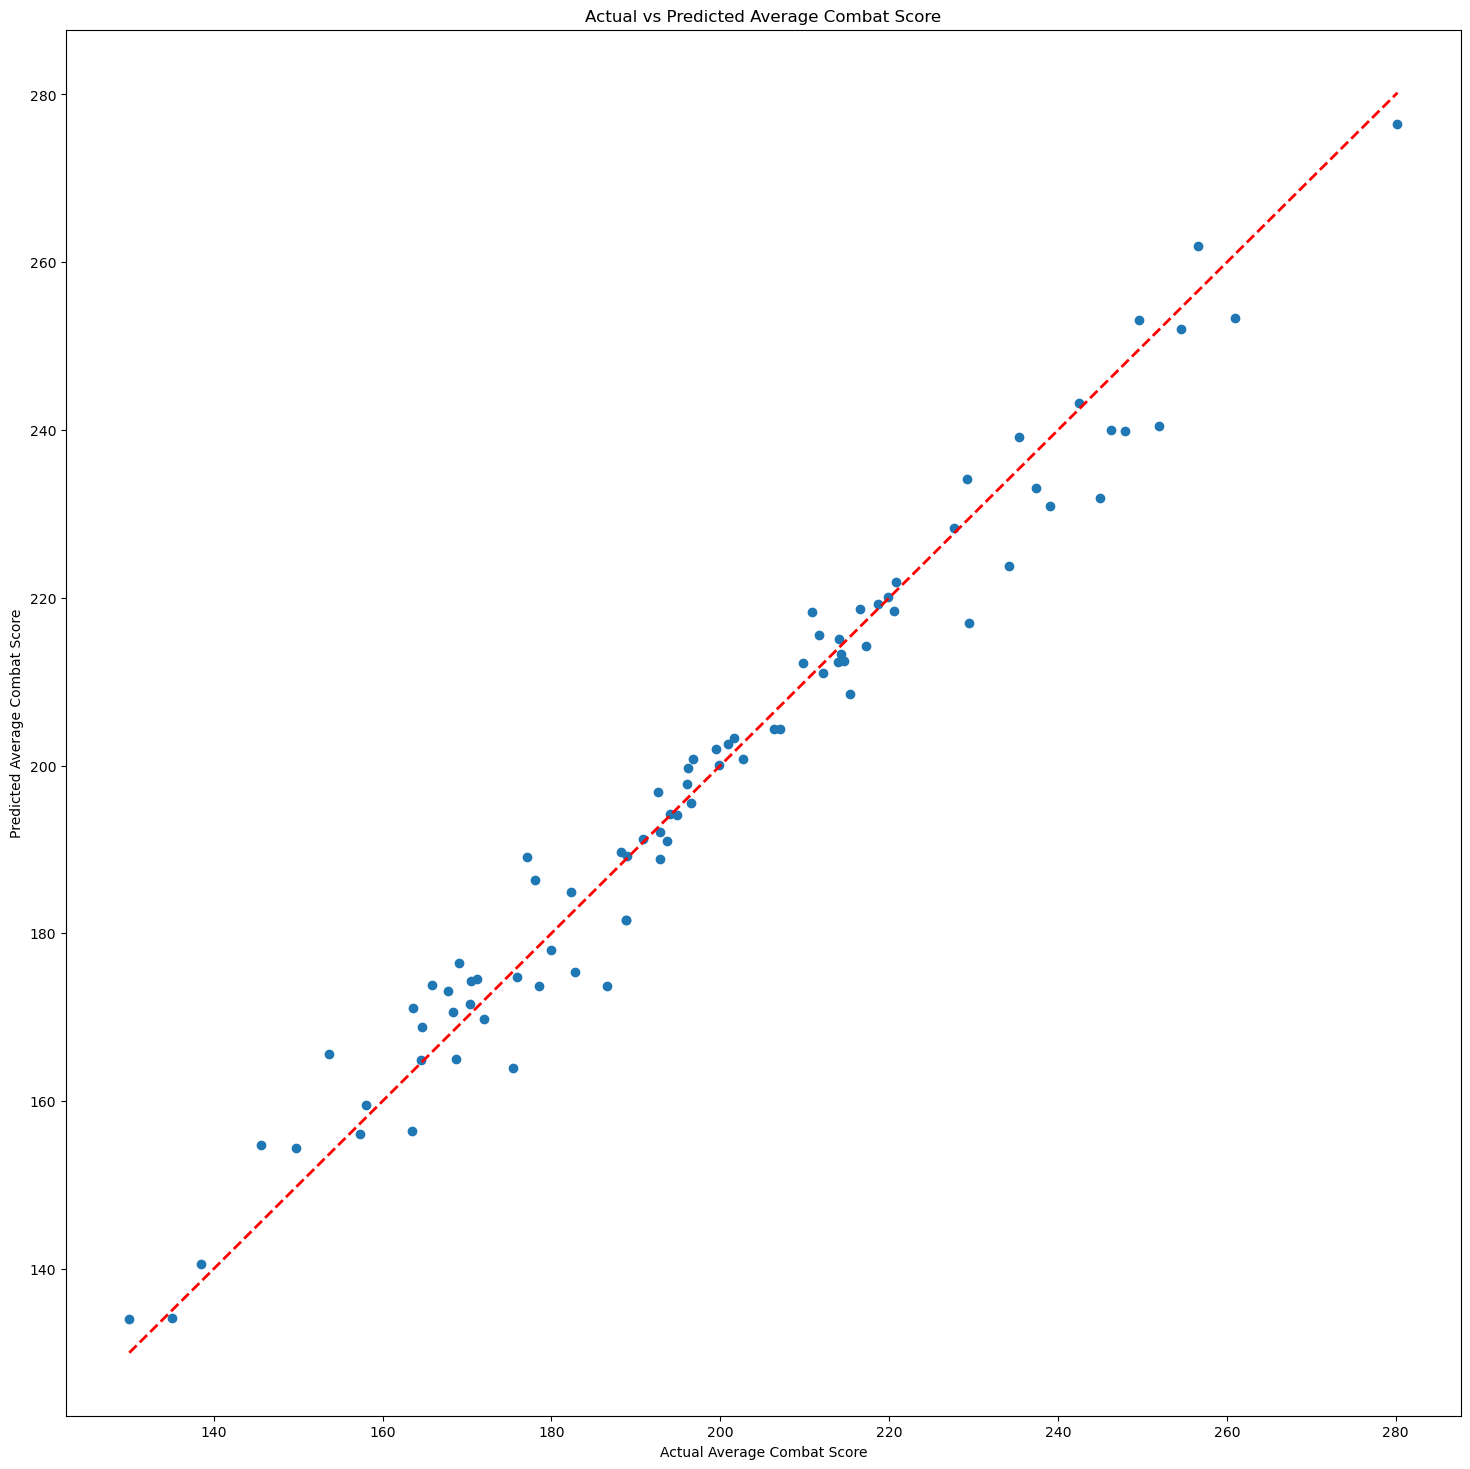

In [19]:
# Actual vs Predicted graph

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
plt.scatter(y_test, predictions_optimized)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Average Combat Score")
plt.ylabel("Predicted Average Combat Score")
plt.title("Actual vs Predicted Average Combat Score")

plt.show()

In [ ]:
#Residual Plot
residuals = y_test - predictions_optimized
plt.scatter(predictions_optimized, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [ ]:
#Distribution of Residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')

In [ ]:
# Actual vs Predicted graph player's highest ACS

df_model_predict = data.assign(predictions = opt.predict(data[features]))
df_only_first = df_model_predict.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')

actual = df_only_first['average_combat_score']
high_predictions = df_only_first['predictions']

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
plt.scatter(actual, high_predictions)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Highest Average Combat Score")
plt.ylabel("Predicted Highest Average Combat Score")
plt.title("Actual vs Predicted Highest Average Combat Score")

# Display player names with a larger offset
for row in df_only_first.itertuples():
    # Add a larger offset to player names
    offset = 10  # Adjust this value based on your preference
    plt.annotate(row.player, (row.average_combat_score, row.predictions), textcoords="offset points", xytext=(0, offset))

# Show the larger plot
plt.show()